In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import akshare as ak
import json
import os
import time

from datetime import datetime, timedelta
from tqdm import tqdm

pd.options.display.max_rows=None
pd.options.display.max_columns=None

In [2]:
# 1. 获取A股所有股票列表
# stock_code_list = ak.stock_info_a_code_name()['code']
# stock_code_list[:5]

## 1. 获取基础原始数据

In [3]:
def get_stock_history_info(stock_code):
    """
    前复权（Forward Adjusted）:
    前复权数据将历史价格向前调整，使得最近的价格不变，而历史价格按照股票的分红、送股和转增等因素进行了调整。这种方式使得历史价格反映了如果投资者持有股票至今所应该得到的收益。前复权数据通常用于图表分析，使得价格连续性更好，并且更适用于基于趋势分析的投资策略。

    后复权（Backward Adjusted）:
    后复权数据将历史价格向后调整，使得历史价格保持不变，而最新的价格根据历史的分红和股权变动进行调整。后复权数据通常用于回测，因为它更贴近实际的交易价格，可以较准确地反映历史的交易情况。

    不复权（Unadjusted）:
    不复权数据是指没有经过任何调整的原始交易数据。不复权数据反映了实际的市场成交价格，但由于不考虑分红和股权变动，因此它不适合用于长期的价格分析。
    """
    result = ak.stock_zh_a_hist(symbol=stock_code, adjust='hfq').rename(
            columns={
                "日期": "datetime",
                "开盘": "open",
                "最高": "high",
                "最低": "low",
                "收盘": "close",
                "成交量": "volume",
                "成交额": "turnover",
                "振幅": "amplitude",
                "涨跌幅": "change_pct",
                "涨跌额": "change_amount",
                "换手率": "turnover_rate",
            }
        )
    result = result[['datetime', 'open', 'high', 'low', 'close', 'volume']]
    result.insert(0, 'stock_code', stock_code)
    return result

In [37]:
stock_code = '000001'
dataframe = get_stock_history_info(stock_code)

In [38]:
from expression_excutor import AlphaExpressionExcutor
expression_excutor = AlphaExpressionExcutor()

In [39]:
# 计算收益：5日收盘价(作为卖出价格)除以明日开盘价(作为买入价格)
expression_1 = "shift(close,-5)/shift(open,-1)"
# 极值处理：用1%和99%分位的值做clip
expression_2 = "clip(label,all_quantile(label, 0.01),all_quantile(label,0.99))"
# 过滤掉一字涨停的情况 (设置label为NaN，在后续处理和训练中会忽略NaN的label)
expression_3 = "where(shift(high,-1)=shift(low,-1), nan, label)"

dataframe['label'] = expression_excutor.excute(dataframe, expression_1)
dataframe['label'] = expression_excutor.excute(dataframe, expression_2)
dataframe['label'] = expression_excutor.excute(dataframe, expression_3)

In [41]:
alpha_dict = json.loads(open('./alpha_184.json', "r").read())

for alpha_name, alpha_expression in alpha_dict.items():
        dataframe[alpha_name] = expression_excutor.excute(dataframe, alpha_expression)

In [46]:
df = dataframe.replace([np.inf, -np.inf], np.nan).dropna()

In [72]:
print([i for i in df.columns])

['stock_code', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'label', 'KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'HIGH0', 'HIGH1', 'HIGH2', 'HIGH3', 'HIGH4', 'LOW0', 'LOW1', 'LOW2', 'LOW3', 'LOW4', 'CLOSE0', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'VOLUME0', 'VOLUME1', 'VOLUME2', 'VOLUME3', 'VOLUME4', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'TSRANK5', 'TSRANK10', 'TSRANK20', 'TSRANK30', 'TSRANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', '

## 4. 模型训练

In [48]:
# 6. 选择固定时间区间的数据
train_start_date = pd.to_datetime('2018-01-01')
train_end_date = pd.to_datetime('2021-12-31')
val_start_date = pd.to_datetime('2022-01-01')
val_end_date = pd.to_datetime('2022-04-01')

train_data = df[(pd.to_datetime(df['datetime']) >= train_start_date) & (pd.to_datetime(df['datetime']) <= train_end_date)]
validation_data = df[(pd.to_datetime(df['datetime']) >= val_start_date) & (pd.to_datetime(df['datetime']) <= val_end_date)]

## 使用Tensorflow

In [51]:
# 使用tensorflow处理原始数据
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2024-03-01 15:46:27.711016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


In [73]:
def get_numeric_boundaries(series, num_bins=40):
    boundaries = pd.qcut(series, num_bins, retbins=True, duplicates='drop')[1].tolist()
    return boundaries

In [75]:
TARGET_FEATURE_NAME = ["label"]

NUMERIC_FEATURES = ['KMID','KLEN','KMID2','KUP','KUP2','KLOW','KLOW2','KSFT','KSFT2','OPEN0','OPEN1','OPEN2','OPEN3','OPEN4','HIGH0','HIGH1','HIGH2','HIGH3','HIGH4','LOW0','LOW1','LOW2','LOW3','LOW4','CLOSE0','CLOSE1','CLOSE2','CLOSE3','CLOSE4','VOLUME0','VOLUME1','VOLUME2','VOLUME3','VOLUME4','ROC5','ROC10','ROC20','ROC30','ROC60','MAX5','MAX10','MAX20','MAX30','MAX60','MIN5','MIN10','MIN20','MIN30','MIN60','MA5','MA10','MA20','MA30','MA60','STD5','STD10','STD20','STD30','STD60','BETA5','BETA10','BETA20','BETA30','BETA60','RSQR5','RSQR10','RSQR20','RSQR30','RSQR60','RESI5','RESI10','RESI20','RESI30','RESI60','QTLU5','QTLU10','QTLU20','QTLU30','QTLU60','QTLD5','QTLD10','QTLD20','QTLD30','QTLD60','TSRANK5','TSRANK10','TSRANK20','TSRANK30','TSRANK60','RSV5','RSV10','RSV20','RSV30','RSV60','IMAX5','IMAX10','IMAX20','IMAX30','IMAX60','IMIN5','IMIN10','IMIN20','IMIN30','IMIN60','IMXD5','IMXD10','IMXD20','IMXD30','IMXD60','CORD5','CORD10','CORD20','CORD30','CORD60','CNTP5','CNTP10','CNTP20','CNTP30','CNTP60','CNTN5','CNTN10','CNTN20','CNTN30','CNTN60','CNTD5','CNTD10','CNTD20','CNTD30','CNTD60','SUMP5','SUMP10','SUMP20','SUMP30','SUMP60','SUMN5','SUMN10','SUMN20','SUMN30','SUMN60','SUMD5','SUMD10','SUMD20','SUMD30','SUMD60','VMA5','VMA10','VMA20','VMA30','VMA60','VSTD5','VSTD10','VSTD20','VSTD30','VSTD60','WVMA5','WVMA10','WVMA20','WVMA30','WVMA60','VSUMP5','VSUMP10','VSUMP20','VSUMP30','VSUMP60','VSUMN5','VSUMN10','VSUMN20','VSUMN30','VSUMN60','VSUMD5','VSUMD10','VSUMD20','VSUMD30','VSUMD60']
NUMERIC_FEATURES_WITH_BOUNDARIES = {k:get_numeric_boundaries(train_data[k])  for k in NUMERIC_FEATURES}

INTEGER_CATEGORICAL_FEATURES = []
INTEGER_CATEGORICAL_FEATURES_WITH_VOCAB = {}

STRING_CATEGORICAL_FEATURES = []
STRING_CATEGORICAL_FEATURES_WITH_VOCAB = {}

FEATURE_NAMES = NUMERIC_FEATURES + INTEGER_CATEGORICAL_FEATURES + STRING_CATEGORICAL_FEATURES

In [90]:
X_train, y_train = train_data[FEATURE_NAMES], train_data[TARGET_FEATURE_NAME]
X_val, y_val = validation_data[FEATURE_NAMES], validation_data[TARGET_FEATURE_NAME]

In [80]:
def create_model_inputs():
    inputs = {}
    # 处理连续特征
    for feature_name in NUMERIC_FEATURES:
        inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )

    # 处理INTEGER离散特征
    for feature_name in INTEGER_CATEGORICAL_FEATURES:
        inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="int32"
            )

    # 处理STRING离散特征
    for feature_name in STRING_CATEGORICAL_FEATURES:
        inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="string"
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    embedding_dim = 6

    # 处理连续特征
    for feature_name, boundaries in NUMERIC_FEATURES_WITH_BOUNDARIES.items():
        
        lookup_layer = tf.keras.layers.Discretization(bin_boundaries=boundaries,output_mode='int')
        embedding = tf.keras.layers.Embedding(
            input_dim=len(boundaries) + 1, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)

    # 处理INTEGER离散特征
    for feature_name, integer_vocab in INTEGER_CATEGORICAL_FEATURES_WITH_VOCAB.items():
        lookup_layer = tf.keras.layers.IntegerLookup(vocabulary=integer_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(integer_vocab) + 1, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)
    
    # 处理STRING离散特征
    for feature_name, string_vocab in STRING_CATEGORICAL_FEATURES_WITH_VOCAB.items():
        lookup_layer = tf.keras.layers.StringLookup(vocabulary=string_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(string_vocab) + 1, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)

    return encoded_features

inputs = create_model_inputs()
encoded_features = encode_inputs(inputs)

In [82]:
class Senet(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=3, seed=1024, **kwargs):
        self.reduction_ratio = reduction_ratio
        self.seed = seed
        super(Senet, self).__init__(**kwargs)

    def build(self, input_shape):
        self.field_size = len(input_shape)
        self.reduction_size = max(1, self.field_size // self.reduction_ratio)
        self.scale_layer = tf.keras.layers.Dense(units=self.reduction_size, activation='relu')
        self.expand_layer = tf.keras.layers.Dense(units=self.field_size, activation='relu')
        super(Senet, self).build(input_shape)

    def call(self, inputs, training=None):
        inputs = tf.concat(inputs, axis=1) # [B, N, dim]
        Z = tf.reduce_mean(inputs, axis=-1) # [B, N]
        A_1 = self.scale_layer(Z) # [B, X]
        A_2 = self.expand_layer(A_1) # [B, N]
        scale_inputs = tf.multiply(inputs, tf.expand_dims(A_2, axis=-1))
        output = scale_inputs + inputs # skip-connection
        return output # [B, N, dim]


class Dnn(tf.keras.layers.Layer):
    def __init__(self, hidden_units, activation="relu", dropout_rate=0.2, use_bn=False, seed=1024, **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        self.seed = seed
        self.dense_layers = []
        self.dropout_layers = []
        self.bn_layers = []
        super(Dnn, self).__init__(**kwargs)
    
    def build(self, input_shape):
        for units in self.hidden_units:
            self.dense_layers.append(tf.keras.layers.Dense(units=units, activation=self.activation))
            self.dropout_layers.append(tf.keras.layers.Dropout(rate=self.dropout_rate, seed=self.seed))
            if self.use_bn:
                self.bn_layers.append(tf.keras.layers.BatchNormalization())
        super(Dnn, self).build(input_shape)  # Be sure to call this at the end
    
    def call(self, inputs, training=None):
        x = inputs
        for i in range(len(self.hidden_units)):
            x = self.dense_layers[i](x)
            if self.use_bn:
                x = self.bn_layers[i](x, training=training)
            x = self.dropout_layers[i](x, training=training)
        return x

In [87]:
class QuantModel(tf.keras.Model):
	def __init__(self, config, **kwargs):
		super(QuantModel, self).__init__(**kwargs)
		self.config = config

		self.senet_layer = Senet(
			reduction_ratio=self.config.get('reduction_ratio', 3), 
			seed=self.config.get('seed', 1024),
		)
		self.dnn_layer = Dnn(
			hidden_units=self.config.get('dnn_hidden_units', [64,32]),
			activation=self.config.get('dnn_activation', 'relu'),
			dropout_rate=self.config.get('dnn_dropout', 0.2),
			use_bn=self.config.get('dnn_use_bn', True)
		)
		self.output_layer = tf.keras.layers.Dense(1, activation=None)
		

	def call(self, inputs, training=None):
		encoded_features = encode_inputs(inputs)
		senet_output = self.senet_layer(encoded_features, training=training)
		senet_output = tf.keras.layers.Flatten(senet_output) # [B, N * dim]
		dnn_output = self.dnn_layer(senet_output, training=training)
		output = self.output_layer(dnn_output, training=training)
		return output

,stock_code,datetime,open,high,low,close,volume,label,KMID,KLEN,KMID2,KUP,KUP2,KLOW,KLOW2,KSFT,KSFT2,OPEN0,OPEN1,OPEN2,OPEN3,OPEN4,HIGH0,HIGH1,HIGH2,HIGH3,HIGH4,LOW0,LOW1,LOW2,LOW3,LOW4,CLOSE0,CLOSE1,CLOSE2,CLOSE3,CLOSE4,VOLUME0,VOLUME1,VOLUME2,VOLUME3,VOLUME4,ROC5,ROC10,ROC20,ROC30,ROC60,MAX5,MAX10,MAX20,MAX30,MAX60,MIN5,MIN10,MIN20,MIN30,MIN60,MA5,MA10,MA20,MA30,MA60,STD5,STD10,STD20,STD30,STD60,BETA5,BETA10,BETA20,BETA30,BETA60,RSQR5,RSQR10,RSQR20,RSQR30,RSQR60,RESI5,RESI10,RESI20,RESI30,RESI60,QTLU5,QTLU10,QTLU20,QTLU30,QTLU60,QTLD5,QTLD10,QTLD20,QTLD30,QTLD60,TSRANK5,TSRANK10,TSRANK20,TSRANK30,TSRANK60,RSV5,RSV10,RSV20,RSV30,RSV60,IMAX5,IMAX10,IMAX20,IMAX30,IMAX60,IMIN5,IMIN10,IMIN20,IMIN30,IMIN60,IMXD5,IMXD10,IMXD20,IMXD30,IMXD60,CORD5,CORD10,CORD20,CORD30,CORD60,CNTP5,CNTP10,CNTP20,CNTP30,CNTP60,CNTN5,CNTN10,CNTN20,CNTN30,CNTN60,CNTD5,CNTD10,CNTD20,CNTD30,CNTD60,SUMP5,SUMP10,SUMP20,SUMP30,SUMP60,SUMN5,SUMN10,SUMN20,SUMN30,SUMN60,SUMD5,SUMD10,SUMD20,SUMD30,SUMD60,VMA5,VMA10,VMA20,VMA30,VMA60,VSTD5,VSTD10,VSTD20,VSTD30,VSTD60,WVMA5,WVMA10,WVMA20,WVMA30,WVMA60,VSUMP5,VSUMP10,VSUMP20,VSUMP30,VSUMP60,VSUMN5,VSUMN10,VSUMN20,VSUMN30,VSUMN60,VSUMD5,VSUMD10,VSUMD20,VSUMD30,VSUMD60
6367,000001,2018-01-02,2228.23,2322.50,2223.36,2285.12,2081593,0.953869,0.025531,0.044493,0.573835,0.016776,0.377043,0.002186,0.049122,0.010941,0.245915,0.975104,0.965148,0.970128,0.991467,0.968706,1.016358,0.980798,0.982929,1.005689,0.999287,0.972973,0.957324,0.951635,0.963726,0.963726,1.0,0.971551,0.965148,0.970837,0.997156,1.0,0.472194,0.746078,0.656501,0.539821,0.967993,0.932432,0.971551,1.039118,0.829300,1.016358,1.016358,1.016358,1.016358,1.016358,0.002188,0.004376,0.008752,0.013128,0.026257,0.980938,0.978733,0.965967,0.983451,0.927796,0.016323,0.013121,0.019814,0.039477,0.072978,0.000640,0.000918,0.001660,-0.002354,0.003068,0.003846,0.044889,0.245784,0.275671,0.539084,0.017781,0.017135,0.018259,0.050688,-0.018306,0.997724,0.990325,0.986058,1.001707,0.986058,0.969700,0.968564,0.951350,0.955048,0.846229,5.0,10.0,20.0,23.5,52.5,0.983871,0.983836,0.983765,0.983695,0.983478,0.0,0.0,0.00,0.933333,0.466667,0.4,0.9,0.50,0.333333,0.666667,-0.4,-0.9,-0.5,0.600000,-0.2,0.085307,0.291894,0.393290,0.297331,0.271429,0.6,0.5,0.45,0.466667,0.500000,0.4,0.5,0.50,0.500000,0.466667,0.2,0.0,-0.05,-0.033333,0.033333,0.666667,0.692308,0.543103,0.467836,0.582988,0.333333,0.307692,0.456897,0.532164,0.417012,0.333333,0.384615,0.086205,-0.064327,0.165975,0.682919,0.693010,0.684679,0.778932,0.695393,0.206222,0.241635,0.219330,0.258516,0.359090,0.762316,0.976635,0.942986,0.873075,1.285542,0.596880,0.586130,0.528651,0.472186,0.512911,0.403120,0.413870,0.471349,0.527814,0.487089,0.193759,0.172261,0.057302,-0.055627,0.025821
6368,000001,2018-01-03,2289.99,2311.12,2203.85,2224.98,2962498,1.010965,-0.028389,0.046843,-0.606041,0.009227,0.196980,0.009227,0.196980,-0.028389,-0.606041,1.029218,1.001461,0.991236,0.996351,1.018265,1.038715,1.043830,1.007308,1.009497,1.032872,0.990503,0.999272,0.983200,0.977357,0.989775,1.0,1.027029,0.997811,0.991236,0.997079,1.0,0.702648,0.331786,0.524230,0.461289,1.024108,0.996351,0.997811,1.081812,0.864134,1.038715,1.038715,1.038715,1.038715,1.038715,0.002247,0.004494,0.008989,0.013483,0.026967,1.002631,1.005553,0.992186,1.007306,0.955139,0.014019,0.013257,0.020388,0.038235,0.074274,0.004164,0.000071,0.001909,-0.001988,0.003078,0.220526,0.000262,0.306869,0.209467,0.523765,-0.010958,-0.005872,-0.010322,0.021517,-0.045936,1.005406,1.017093,1.012710,1.027029,1.012710,0.995910,0.994743,0.977065,0.980863,0.869248,4.0,6.0,15.0,18.0,46.0,0.962647,0.962566,0.962403,0.962238,0.961735,0.2,0.1,0.05,0.966667,0.483333,0.6,0.3,0.55,0.366667,0.683333,-0.4,-0.2,-0.5,0.600000,-0.2,0.283575,-0.114669,0.337841,0.273088,0.265908,0.4,0.4,0.45,0.433333,0.483333,0.6,0.6,0.55,0.533333,0.483333,-0.2,-0.2,-0.10,-0.100000,0.000000,0.374037,0.510814,0.502990,0.435781,0.563437,0.625963,0.489186,0.497010,0.564219,0.436563,-0.251926,0.021628,0.005981,-0.128439,0.126874,0.603991,

In [91]:
model_config = {
    "seed": 1024,
    "reduction_ratio": 3,
    "dnn_hidden_units": [64,32],
    "dnn_activation": 'relu',
    "dnn_dropout": 0.2,
    "dnn_use_bn": True
}

quant_model = QuantModel(model_config)

model = tf.keras.models.Model(inputs=[v for k, v in inputs.items()], outputs=quant_model(inputs))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer, loss=loss)
model.fit(X_train, y_train, epochs=2, batch_size=64)

ValueError: Exception encountered when calling layer "quant_model_2" (type QuantModel).

in user code:

    File "/var/folders/vc/j8df25m509sdsv8x_v9j7gk00000ks/T/ipykernel_33444/3240950507.py", line 21, in call  *
        senet_output = self.senet_layer(encoded_features, training=training)
    File "/Users/alsc/VscodeProject/hh_quant/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/vc/j8df25m509sdsv8x_v9j7gk00000ks/T/__autograph_generated_filee6_kdqat.py", line 12, in tf__call
        A_1 = ag__.converted_call(ag__.ld(self).scale_layer, (ag__.ld(Z),), None, fscope)

    ValueError: Exception encountered when calling layer 'senet_3' (type Senet).
    
    in user code:
    
        File "/var/folders/vc/j8df25m509sdsv8x_v9j7gk00000ks/T/ipykernel_33444/2064477366.py", line 17, in call  *
            A_1 = self.scale_layer(Z) # [B, X]
        File "/Users/alsc/VscodeProject/hh_quant/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/Users/alsc/VscodeProject/hh_quant/.venv/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    
    Call arguments received by layer 'senet_3' (type Senet):
      • inputs=['tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)']
      • training=None


Call arguments received by layer "quant_model_2" (type QuantModel):
  • inputs={'KMID': 'tf.Tensor(shape=(None,), dtype=float32)', 'KLEN': 'tf.Tensor(shape=(None,), dtype=float32)', 'KMID2': 'tf.Tensor(shape=(None,), dtype=float32)', 'KUP': 'tf.Tensor(shape=(None,), dtype=float32)', 'KUP2': 'tf.Tensor(shape=(None,), dtype=float32)', 'KLOW': 'tf.Tensor(shape=(None,), dtype=float32)', 'KLOW2': 'tf.Tensor(shape=(None,), dtype=float32)', 'KSFT': 'tf.Tensor(shape=(None,), dtype=float32)', 'KSFT2': 'tf.Tensor(shape=(None,), dtype=float32)', 'OPEN0': 'tf.Tensor(shape=(None,), dtype=float32)', 'OPEN1': 'tf.Tensor(shape=(None,), dtype=float32)', 'OPEN2': 'tf.Tensor(shape=(None,), dtype=float32)', 'OPEN3': 'tf.Tensor(shape=(None,), dtype=float32)', 'OPEN4': 'tf.Tensor(shape=(None,), dtype=float32)', 'HIGH0': 'tf.Tensor(shape=(None,), dtype=float32)', 'HIGH1': 'tf.Tensor(shape=(None,), dtype=float32)', 'HIGH2': 'tf.Tensor(shape=(None,), dtype=float32)', 'HIGH3': 'tf.Tensor(shape=(None,), dtype=float32)', 'HIGH4': 'tf.Tensor(shape=(None,), dtype=float32)', 'LOW0': 'tf.Tensor(shape=(None,), dtype=float32)', 'LOW1': 'tf.Tensor(shape=(None,), dtype=float32)', 'LOW2': 'tf.Tensor(shape=(None,), dtype=float32)', 'LOW3': 'tf.Tensor(shape=(None,), dtype=float32)', 'LOW4': 'tf.Tensor(shape=(None,), dtype=float32)', 'CLOSE0': 'tf.Tensor(shape=(None,), dtype=float32)', 'CLOSE1': 'tf.Tensor(shape=(None,), dtype=float32)', 'CLOSE2': 'tf.Tensor(shape=(None,), dtype=float32)', 'CLOSE3': 'tf.Tensor(shape=(None,), dtype=float32)', 'CLOSE4': 'tf.Tensor(shape=(None,), dtype=float32)', 'VOLUME0': 'tf.Tensor(shape=(None,), dtype=float32)', 'VOLUME1': 'tf.Tensor(shape=(None,), dtype=float32)', 'VOLUME2': 'tf.Tensor(shape=(None,), dtype=float32)', 'VOLUME3': 'tf.Tensor(shape=(None,), dtype=float32)', 'VOLUME4': 'tf.Tensor(shape=(None,), dtype=float32)', 'ROC5': 'tf.Tensor(shape=(None,), dtype=float32)', 'ROC10': 'tf.Tensor(shape=(None,), dtype=float32)', 'ROC20': 'tf.Tensor(shape=(None,), dtype=float32)', 'ROC30': 'tf.Tensor(shape=(None,), dtype=float32)', 'ROC60': 'tf.Tensor(shape=(None,), dtype=float32)', 'MAX5': 'tf.Tensor(shape=(None,), dtype=float32)', 'MAX10': 'tf.Tensor(shape=(None,), dtype=float32)', 'MAX20': 'tf.Tensor(shape=(None,), dtype=float32)', 'MAX30': 'tf.Tensor(shape=(None,), dtype=float32)', 'MAX60': 'tf.Tensor(shape=(None,), dtype=float32)', 'MIN5': 'tf.Tensor(shape=(None,), dtype=float32)', 'MIN10': 'tf.Tensor(shape=(None,), dtype=float32)', 'MIN20': 'tf.Tensor(shape=(None,), dtype=float32)', 'MIN30': 'tf.Tensor(shape=(None,), dtype=float32)', 'MIN60': 'tf.Tensor(shape=(None,), dtype=float32)', 'MA5': 'tf.Tensor(shape=(None,), dtype=float32)', 'MA10': 'tf.Tensor(shape=(None,), dtype=float32)', 'MA20': 'tf.Tensor(shape=(None,), dtype=float32)', 'MA30': 'tf.Tensor(shape=(None,), dtype=float32)', 'MA60': 'tf.Tensor(shape=(None,), dtype=float32)', 'STD5': 'tf.Tensor(shape=(None,), dtype=float32)', 'STD10': 'tf.Tensor(shape=(None,), dtype=float32)', 'STD20': 'tf.Tensor(shape=(None,), dtype=float32)', 'STD30': 'tf.Tensor(shape=(None,), dtype=float32)', 'STD60': 'tf.Tensor(shape=(None,), dtype=float32)', 'BETA5': 'tf.Tensor(shape=(None,), dtype=float32)', 'BETA10': 'tf.Tensor(shape=(None,), dtype=float32)', 'BETA20': 'tf.Tensor(shape=(None,), dtype=float32)', 'BETA30': 'tf.Tensor(shape=(None,), dtype=float32)', 'BETA60': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSQR5': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSQR10': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSQR20': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSQR30': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSQR60': 'tf.Tensor(shape=(None,), dtype=float32)', 'RESI5': 'tf.Tensor(shape=(None,), dtype=float32)', 'RESI10': 'tf.Tensor(shape=(None,), dtype=float32)', 'RESI20': 'tf.Tensor(shape=(None,), dtype=float32)', 'RESI30': 'tf.Tensor(shape=(None,), dtype=float32)', 'RESI60': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLU5': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLU10': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLU20': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLU30': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLU60': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLD5': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLD10': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLD20': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLD30': 'tf.Tensor(shape=(None,), dtype=float32)', 'QTLD60': 'tf.Tensor(shape=(None,), dtype=float32)', 'TSRANK5': 'tf.Tensor(shape=(None,), dtype=float32)', 'TSRANK10': 'tf.Tensor(shape=(None,), dtype=float32)', 'TSRANK20': 'tf.Tensor(shape=(None,), dtype=float32)', 'TSRANK30': 'tf.Tensor(shape=(None,), dtype=float32)', 'TSRANK60': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSV5': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSV10': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSV20': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSV30': 'tf.Tensor(shape=(None,), dtype=float32)', 'RSV60': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMAX5': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMAX10': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMAX20': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMAX30': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMAX60': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMIN5': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMIN10': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMIN20': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMIN30': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMIN60': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMXD5': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMXD10': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMXD20': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMXD30': 'tf.Tensor(shape=(None,), dtype=float32)', 'IMXD60': 'tf.Tensor(shape=(None,), dtype=float32)', 'CORD5': 'tf.Tensor(shape=(None,), dtype=float32)', 'CORD10': 'tf.Tensor(shape=(None,), dtype=float32)', 'CORD20': 'tf.Tensor(shape=(None,), dtype=float32)', 'CORD30': 'tf.Tensor(shape=(None,), dtype=float32)', 'CORD60': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTP5': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTP10': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTP20': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTP30': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTP60': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTN5': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTN10': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTN20': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTN30': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTN60': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTD5': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTD10': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTD20': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTD30': 'tf.Tensor(shape=(None,), dtype=float32)', 'CNTD60': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMP5': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMP10': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMP20': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMP30': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMP60': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMN5': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMN10': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMN20': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMN30': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMN60': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMD5': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMD10': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMD20': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMD30': 'tf.Tensor(shape=(None,), dtype=float32)', 'SUMD60': 'tf.Tensor(shape=(None,), dtype=float32)', 'VMA5': 'tf.Tensor(shape=(None,), dtype=float32)', 'VMA10': 'tf.Tensor(shape=(None,), dtype=float32)', 'VMA20': 'tf.Tensor(shape=(None,), dtype=float32)', 'VMA30': 'tf.Tensor(shape=(None,), dtype=float32)', 'VMA60': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSTD5': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSTD10': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSTD20': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSTD30': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSTD60': 'tf.Tensor(shape=(None,), dtype=float32)', 'WVMA5': 'tf.Tensor(shape=(None,), dtype=float32)', 'WVMA10': 'tf.Tensor(shape=(None,), dtype=float32)', 'WVMA20': 'tf.Tensor(shape=(None,), dtype=float32)', 'WVMA30': 'tf.Tensor(shape=(None,), dtype=float32)', 'WVMA60': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMP5': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMP10': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMP20': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMP30': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMP60': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMN5': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMN10': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMN20': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMN30': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMN60': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMD5': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMD10': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMD20': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMD30': 'tf.Tensor(shape=(None,), dtype=float32)', 'VSUMD60': 'tf.Tensor(shape=(None,), dtype=float32)'}
  • training=None

In [ ]:
def get_numeric_boundaries(series, num_bins=40):
    boundaries = pd.qcut(series, num_bins, retbins=True, duplicates='drop')[1].tolist()
    return boundaries

TARGET_FEATURE_NAME = "label1"

# 连续特征分桶
NUMERIC_FEATURES = {
    'total_shares': get_numeric_boundaries(train_data['total_shares']),
    'circulating_shares': get_numeric_boundaries(train_data['circulating_shares']),
    'total_market_cap': get_numeric_boundaries(train_data['total_market_cap']),
    'circulating_market_cap': get_numeric_boundaries(train_data['circulating_market_cap']),
    'turnover_rate': get_numeric_boundaries(train_data['turnover_rate']),
    'pe': get_numeric_boundaries(train_data['pe']),
    'pe_ttm': get_numeric_boundaries(train_data['pe_ttm']),
    'pb': get_numeric_boundaries(train_data['pb']),
    'ps': get_numeric_boundaries(train_data['ps']),
    'ps_ttm': get_numeric_boundaries(train_data['ps_ttm']),
    'total_mv': get_numeric_boundaries(train_data['total_mv']),
    "KMID": get_numeric_boundaries(train_data["KMID"]),
    "KLEN": get_numeric_boundaries(train_data["KLEN"]),
    "KMID2": get_numeric_boundaries(train_data["KMID2"]),
    "KUP": get_numeric_boundaries(train_data["KUP"]),
    "KUP2": get_numeric_boundaries(train_data["KUP2"]),
    "KLOW": get_numeric_boundaries(train_data["KLOW"]),
    "KLOW2": get_numeric_boundaries(train_data["KLOW2"]),
    "KSFT": get_numeric_boundaries(train_data["KSFT"]),
    "KSFT2": get_numeric_boundaries(train_data["KSFT2"]),
    "OPEN0": get_numeric_boundaries(train_data["OPEN0"]),
    "OPEN1": get_numeric_boundaries(train_data["OPEN1"]),
    "OPEN2": get_numeric_boundaries(train_data["OPEN2"]),
    "OPEN3": get_numeric_boundaries(train_data["OPEN3"]),
    "OPEN4": get_numeric_boundaries(train_data["OPEN4"]),
    "HIGH0": get_numeric_boundaries(train_data["HIGH0"]),
    "HIGH1": get_numeric_boundaries(train_data["HIGH1"]),
    "HIGH2": get_numeric_boundaries(train_data["HIGH2"]),
    "HIGH3": get_numeric_boundaries(train_data["HIGH3"]),
    "HIGH4": get_numeric_boundaries(train_data["HIGH4"]),
    "LOW0": get_numeric_boundaries(train_data["LOW0"]),
    "LOW1": get_numeric_boundaries(train_data["LOW1"]),
    "LOW2": get_numeric_boundaries(train_data["LOW2"]),
    "LOW3": get_numeric_boundaries(train_data["LOW3"]),
    "LOW4": get_numeric_boundaries(train_data["LOW4"]),
    "CLOSE0": get_numeric_boundaries(train_data["CLOSE0"]),
    "CLOSE1": get_numeric_boundaries(train_data["CLOSE1"]),
    "CLOSE2": get_numeric_boundaries(train_data["CLOSE2"]),
    "CLOSE3": get_numeric_boundaries(train_data["CLOSE3"]),
    "CLOSE4": get_numeric_boundaries(train_data["CLOSE4"]),
    "VWAP0": get_numeric_boundaries(train_data["VWAP0"]),
    "VWAP1": get_numeric_boundaries(train_data["VWAP1"]),
    "VWAP2": get_numeric_boundaries(train_data["VWAP2"]),
    "VWAP3": get_numeric_boundaries(train_data["VWAP3"]),
    "VWAP4": get_numeric_boundaries(train_data["VWAP4"]),
    "VOLUME0": get_numeric_boundaries(train_data["VOLUME0"]),
    "VOLUME1": get_numeric_boundaries(train_data["VOLUME1"]),
    "VOLUME2": get_numeric_boundaries(train_data["VOLUME2"]),
    "VOLUME3": get_numeric_boundaries(train_data["VOLUME3"]),
    "VOLUME4": get_numeric_boundaries(train_data["VOLUME4"]),
    "ROC5": get_numeric_boundaries(train_data["ROC5"]),
    "ROC10": get_numeric_boundaries(train_data["ROC10"]),
    "ROC20": get_numeric_boundaries(train_data["ROC20"]),
    "ROC30": get_numeric_boundaries(train_data["ROC30"]),
    "ROC60": get_numeric_boundaries(train_data["ROC60"]),
    "MAX5": get_numeric_boundaries(train_data["MAX5"]),
    "MAX10": get_numeric_boundaries(train_data["MAX10"]),
    "MAX20": get_numeric_boundaries(train_data["MAX20"]),
    "MAX30": get_numeric_boundaries(train_data["MAX30"]),
    "MAX60": get_numeric_boundaries(train_data["MAX60"]),
    "MIN5": get_numeric_boundaries(train_data["MIN5"]),
    "MIN10": get_numeric_boundaries(train_data["MIN10"]),
    "MIN20": get_numeric_boundaries(train_data["MIN20"]),
    "MIN30": get_numeric_boundaries(train_data["MIN30"]),
    "MIN60": get_numeric_boundaries(train_data["MIN60"]),
    "MA5": get_numeric_boundaries(train_data["MA5"]),
    "MA10": get_numeric_boundaries(train_data["MA10"]),
    "MA20": get_numeric_boundaries(train_data["MA20"]),
    "MA30": get_numeric_boundaries(train_data["MA30"]),
    "MA60": get_numeric_boundaries(train_data["MA60"]),
    "STD5": get_numeric_boundaries(train_data["STD5"]),
    "STD10": get_numeric_boundaries(train_data["STD10"]),
    "STD20": get_numeric_boundaries(train_data["STD20"]),
    "STD30": get_numeric_boundaries(train_data["STD30"]),
    "STD60": get_numeric_boundaries(train_data["STD60"]),
    "BETA5": get_numeric_boundaries(train_data["BETA5"]),
    "BETA10": get_numeric_boundaries(train_data["BETA10"]),
    "BETA20": get_numeric_boundaries(train_data["BETA20"]),
    "BETA30": get_numeric_boundaries(train_data["BETA30"]),
    "BETA60": get_numeric_boundaries(train_data["BETA60"]),
    "RSQR5": get_numeric_boundaries(train_data["RSQR5"]),
    "RSQR10": get_numeric_boundaries(train_data["RSQR10"]),
    "RSQR20": get_numeric_boundaries(train_data["RSQR20"]),
    "RSQR30": get_numeric_boundaries(train_data["RSQR30"]),
    "RSQR60": get_numeric_boundaries(train_data["RSQR60"]),
    "RESI5": get_numeric_boundaries(train_data["RESI5"]),
    "RESI10": get_numeric_boundaries(train_data["RESI10"]),
    "RESI20": get_numeric_boundaries(train_data["RESI20"]),
    "RESI30": get_numeric_boundaries(train_data["RESI30"]),
    "RESI60": get_numeric_boundaries(train_data["RESI60"]),
    "QTLU5": get_numeric_boundaries(train_data["QTLU5"]),
    "QTLU10": get_numeric_boundaries(train_data["QTLU10"]),
    "QTLU20": get_numeric_boundaries(train_data["QTLU20"]),
    "QTLU30": get_numeric_boundaries(train_data["QTLU30"]),
    "QTLU60": get_numeric_boundaries(train_data["QTLU60"]),
    "QTLD5": get_numeric_boundaries(train_data["QTLD5"]),
    "QTLD10": get_numeric_boundaries(train_data["QTLD10"]),
    "QTLD20": get_numeric_boundaries(train_data["QTLD20"]),
    "QTLD30": get_numeric_boundaries(train_data["QTLD30"]),
    "QTLD60": get_numeric_boundaries(train_data["QTLD60"]),
    # "TSRANK5": get_numeric_boundaries(train_data["TSRANK5"]),
    # "TSRANK10": get_numeric_boundaries(train_data["TSRANK10"]),
    # "TSRANK20": get_numeric_boundaries(train_data["TSRANK20"]),
    # "TSRANK30": get_numeric_boundaries(train_data["TSRANK30"]),
    # "TSRANK60": get_numeric_boundaries(train_data["TSRANK60"]),
    "RSV5": get_numeric_boundaries(train_data["RSV5"]),
    "RSV10": get_numeric_boundaries(train_data["RSV10"]),
    "RSV20": get_numeric_boundaries(train_data["RSV20"]),
    "RSV30": get_numeric_boundaries(train_data["RSV30"]),
    "RSV60": get_numeric_boundaries(train_data["RSV60"]),
    "IMAX5": get_numeric_boundaries(train_data["IMAX5"]),
    "IMAX10": get_numeric_boundaries(train_data["IMAX10"]),
    "IMAX20": get_numeric_boundaries(train_data["IMAX20"]),
    "IMAX30": get_numeric_boundaries(train_data["IMAX30"]),
    "IMAX60": get_numeric_boundaries(train_data["IMAX60"]),
    "IMIN5": get_numeric_boundaries(train_data["IMIN5"]),
    "IMIN10": get_numeric_boundaries(train_data["IMIN10"]),
    "IMIN20": get_numeric_boundaries(train_data["IMIN20"]),
    "IMIN30": get_numeric_boundaries(train_data["IMIN30"]),
    "IMIN60": get_numeric_boundaries(train_data["IMIN60"]),
    "IMXD5": get_numeric_boundaries(train_data["IMXD5"]),
    "IMXD10": get_numeric_boundaries(train_data["IMXD10"]),
    "IMXD20": get_numeric_boundaries(train_data["IMXD20"]),
    "IMXD30": get_numeric_boundaries(train_data["IMXD30"]),
    "IMXD60": get_numeric_boundaries(train_data["IMXD60"]),
    "CORR5": get_numeric_boundaries(train_data["CORR5"]),
    "CORR10": get_numeric_boundaries(train_data["CORR10"]),
    "CORR20": get_numeric_boundaries(train_data["CORR20"]),
    "CORR30": get_numeric_boundaries(train_data["CORR30"]),
    "CORR60": get_numeric_boundaries(train_data["CORR60"]),
    "CORD5": get_numeric_boundaries(train_data["CORD5"]),
    "CORD10": get_numeric_boundaries(train_data["CORD10"]),
    "CORD20": get_numeric_boundaries(train_data["CORD20"]),
    "CORD30": get_numeric_boundaries(train_data["CORD30"]),
    "CORD60": get_numeric_boundaries(train_data["CORD60"]),
    "CNTP5": get_numeric_boundaries(train_data["CNTP5"]),
    "CNTP10": get_numeric_boundaries(train_data["CNTP10"]),
    "CNTP20": get_numeric_boundaries(train_data["CNTP20"]),
    "CNTP30": get_numeric_boundaries(train_data["CNTP30"]),
    "CNTP60": get_numeric_boundaries(train_data["CNTP60"]),
    "CNTN5": get_numeric_boundaries(train_data["CNTN5"]),
    "CNTN10": get_numeric_boundaries(train_data["CNTN10"]),
    "CNTN20": get_numeric_boundaries(train_data["CNTN20"]),
    "CNTN30": get_numeric_boundaries(train_data["CNTN30"]),
    "CNTN60": get_numeric_boundaries(train_data["CNTN60"]),
    "CNTD5": get_numeric_boundaries(train_data["CNTD5"]),
    "CNTD10": get_numeric_boundaries(train_data["CNTD10"]),
    "CNTD20": get_numeric_boundaries(train_data["CNTD20"]),
    "CNTD30": get_numeric_boundaries(train_data["CNTD30"]),
    "CNTD60": get_numeric_boundaries(train_data["CNTD60"]),
    "SUMP5": get_numeric_boundaries(train_data["SUMP5"]),
    "SUMP10": get_numeric_boundaries(train_data["SUMP10"]),
    "SUMP20": get_numeric_boundaries(train_data["SUMP20"]),
    "SUMP30": get_numeric_boundaries(train_data["SUMP30"]),
    "SUMP60": get_numeric_boundaries(train_data["SUMP60"]),
    "SUMN5": get_numeric_boundaries(train_data["SUMN5"]),
    "SUMN10": get_numeric_boundaries(train_data["SUMN10"]),
    "SUMN20": get_numeric_boundaries(train_data["SUMN20"]),
    "SUMN30": get_numeric_boundaries(train_data["SUMN30"]),
    "SUMN60": get_numeric_boundaries(train_data["SUMN60"]),
    "SUMD5": get_numeric_boundaries(train_data["SUMD5"]),
    "SUMD10": get_numeric_boundaries(train_data["SUMD10"]),
    "SUMD20": get_numeric_boundaries(train_data["SUMD20"]),
    "SUMD30": get_numeric_boundaries(train_data["SUMD30"]),
    "SUMD60": get_numeric_boundaries(train_data["SUMD60"]),
    "VMA5": get_numeric_boundaries(train_data["VMA5"]),
    "VMA10": get_numeric_boundaries(train_data["VMA10"]),
    "VMA20": get_numeric_boundaries(train_data["VMA20"]),
    "VMA30": get_numeric_boundaries(train_data["VMA30"]),
    "VMA60": get_numeric_boundaries(train_data["VMA60"]),
    "VSTD5": get_numeric_boundaries(train_data["VSTD5"]),
    "VSTD10": get_numeric_boundaries(train_data["VSTD10"]),
    "VSTD20": get_numeric_boundaries(train_data["VSTD20"]),
    "VSTD30": get_numeric_boundaries(train_data["VSTD30"]),
    "VSTD60": get_numeric_boundaries(train_data["VSTD60"]),
    "WVMA5": get_numeric_boundaries(train_data["WVMA5"]),
    "WVMA10": get_numeric_boundaries(train_data["WVMA10"]),
    "WVMA20": get_numeric_boundaries(train_data["WVMA20"]),
    "WVMA30": get_numeric_boundaries(train_data["WVMA30"]),
    "WVMA60": get_numeric_boundaries(train_data["WVMA60"]),
    "VSUMP5": get_numeric_boundaries(train_data["VSUMP5"]),
    "VSUMP10": get_numeric_boundaries(train_data["VSUMP10"]),
    "VSUMP20": get_numeric_boundaries(train_data["VSUMP20"]),
    "VSUMP30": get_numeric_boundaries(train_data["VSUMP30"]),
    "VSUMP60": get_numeric_boundaries(train_data["VSUMP60"]),
    "VSUMN5": get_numeric_boundaries(train_data["VSUMN5"]),
    "VSUMN10": get_numeric_boundaries(train_data["VSUMN10"]),
    "VSUMN20": get_numeric_boundaries(train_data["VSUMN20"]),
    "VSUMN30": get_numeric_boundaries(train_data["VSUMN30"]),
    "VSUMN60": get_numeric_boundaries(train_data["VSUMN60"]),
    "VSUMD5": get_numeric_boundaries(train_data["VSUMD5"]),
    "VSUMD10": get_numeric_boundaries(train_data["VSUMD10"]),
    "VSUMD20": get_numeric_boundaries(train_data["VSUMD20"]),
    "VSUMD30": get_numeric_boundaries(train_data["VSUMD30"]),
    "VSUMD60": get_numeric_boundaries(train_data["VSUMD60"]),
}

# 离散特征embedding
INTEGER_CATEGORICAL_FEATURES = {
    'weekday': train_data['weekday'].unique().tolist(),
    'day_of_month': train_data['day_of_month'].unique().tolist(),
    'month': train_data['month'].unique().tolist(),
    # 'TSRANK5': train_data['TSRANK5'].unique().tolist(),
    # 'TSRANK10': train_data['TSRANK10'].unique().tolist(),
    # 'TSRANK20': train_data['TSRANK20'].unique().tolist(),
    # 'TSRANK30': train_data['TSRANK30'].unique().tolist(),
    # 'TSRANK60': train_data['TSRANK60'].unique().tolist(),
}
STRING_CATEGORICAL_FEATURES = {
    'industry': train_data['industry'].unique().tolist(),
    'day_of_week': train_data['day_of_week'].unique().tolist(),
    'season': train_data['season'].unique().tolist(),
}


FEATURE_NAMES = list(NUMERIC_FEATURES.keys()) + list(INTEGER_CATEGORICAL_FEATURES.keys()) + list(STRING_CATEGORICAL_FEATURES.keys())

In [32]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURES:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        elif feature_name in INTEGER_CATEGORICAL_FEATURES:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="int32"
            )
        else:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="string"
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    embedding_dim = 6
    is_embedding = True

    # 处理连续特征
    for feature_name, boundaries in NUMERIC_FEATURES.items():
        if is_embedding:
            lookup_layer = tf.keras.layers.Discretization(bin_boundaries=boundaries,output_mode='int')
            embedding = tf.keras.layers.Embedding(
                input_dim=len(boundaries) + 1, output_dim=embedding_dim
            )
            encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        else:
            lookup_layer = tf.keras.layers.Discretization(bin_boundaries=boundaries,output_mode='one_hot')
            encoded_feature = lookup_layer(inputs[feature_name])
        encoded_features.append(encoded_feature)

    # 处理INTEGER离散特征
    for feature_name, integer_vocab in INTEGER_CATEGORICAL_FEATURES.items():
        lookup_layer = tf.keras.layers.IntegerLookup(vocabulary=integer_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(integer_vocab) + 1, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)
    
    # 处理STRING离散特征
    for feature_name, string_vocab in STRING_CATEGORICAL_FEATURES.items():
        lookup_layer = tf.keras.layers.StringLookup(vocabulary=string_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(string_vocab) + 1, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)
    
    print(f"Total Features Size:: {len(encoded_features)}")
    all_features = tf.keras.layers.concatenate(encoded_features)
    return all_features

In [33]:
LEARNING_RATE = 5e-3
NUM_EPOCH = 20

def run_experiment(model, train_ds, val_ds, test_ds):
    # optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE) # for mac M1/M2
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # for mac M1/M2
    
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
        
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True,
    )
    print("Start training the model...")
    history = model.fit(
        train_ds, 
        epochs=NUM_EPOCH,
        validation_data=val_ds, 
        verbose=2,
        callbacks=[early_stopping],
        class_weight=class_weight
    )
    print("Model training finished")

    # loss, auc = model.evaluate(test_ds, verbose=0)
    # print(f"Test AUC::{round(auc * 100, 2)}%")

In [34]:
dropout_rate = 0.2
hidden_units = [128, 32]

In [35]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = tf.keras.layers.Dense(units)(features)
        features = tf.keras.layers.BatchNormalization()(features)
        features = tf.keras.layers.ReLU()(features)
        features = tf.keras.layers.Dropout(dropout_rate)(features)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

baseline_model = create_baseline_model()
# tf.keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")
run_experiment(baseline_model, train_ds, val_ds, test_ds)

Total Features Size:: 196
Start training the model...
Epoch 1/20
879/879 - 53s - loss: 0.6766 - tp: 19124.0000 - fp: 34636.0000 - tn: 45405.0000 - fn: 13300.0000 - accuracy: 0.5738 - precision: 0.3557 - recall: 0.5898 - auc: 0.6080 - val_loss: 0.6920 - val_tp: 1801.0000 - val_fp: 4452.0000 - val_tn: 4455.0000 - val_fn: 1178.0000 - val_accuracy: 0.5263 - val_precision: 0.2880 - val_recall: 0.6046 - val_auc: 0.5721 - 53s/epoch - 60ms/step
Epoch 2/20
879/879 - 24s - loss: 0.6381 - tp: 21462.0000 - fp: 31439.0000 - tn: 48602.0000 - fn: 10962.0000 - accuracy: 0.6230 - precision: 0.4057 - recall: 0.6619 - auc: 0.6850 - val_loss: 0.7583 - val_tp: 1899.0000 - val_fp: 4828.0000 - val_tn: 4079.0000 - val_fn: 1080.0000 - val_accuracy: 0.5029 - val_precision: 0.2823 - val_recall: 0.6375 - val_auc: 0.5596 - 24s/epoch - 28ms/step
Epoch 3/20
879/879 - 25s - loss: 0.6027 - tp: 22606.0000 - fp: 28416.0000 - tn: 51625.0000 - fn: 9818.0000 - accuracy: 0.6600 - precision: 0.4431 - recall: 0.6972 - auc: 0.

2024-02-23 16:41:25.714555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 102318 of 112465
2024-02-23 16:41:26.773264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


879/879 - 29s - loss: 0.5095 - tp: 25253.0000 - fp: 22573.0000 - tn: 57468.0000 - fn: 7171.0000 - accuracy: 0.7355 - precision: 0.5280 - recall: 0.7788 - auc: 0.8266 - val_loss: 0.7876 - val_tp: 1569.0000 - val_fp: 3948.0000 - val_tn: 4959.0000 - val_fn: 1410.0000 - val_accuracy: 0.5492 - val_precision: 0.2844 - val_recall: 0.5267 - val_auc: 0.5581 - 29s/epoch - 33ms/step
Epoch 6/20
879/879 - 27s - loss: 0.4581 - tp: 26309.0000 - fp: 19606.0000 - tn: 60435.0000 - fn: 6115.0000 - accuracy: 0.7713 - precision: 0.5730 - recall: 0.8114 - auc: 0.8641 - val_loss: 0.8215 - val_tp: 1571.0000 - val_fp: 3954.0000 - val_tn: 4953.0000 - val_fn: 1408.0000 - val_accuracy: 0.5489 - val_precision: 0.2843 - val_recall: 0.5274 - val_auc: 0.5575 - 27s/epoch - 30ms/step
Epoch 7/20
879/879 - 27s - loss: 0.4109 - tp: 27103.0000 - fp: 16927.0000 - tn: 63114.0000 - fn: 5321.0000 - accuracy: 0.8022 - precision: 0.6156 - recall: 0.8359 - auc: 0.8931 - val_loss: 0.8674 - val_tp: 1448.0000 - val_fp: 3820.0000 - v

In [36]:
# baseline_model.save('./stock_selection_base_model')
# reloaded_model = tf.keras.models.load_model('./stock_selection_base_model')

In [37]:
# samples = df_to_dataset(test_data.iloc[:100, :], shuffle=False, batch_size=10)

In [38]:
test_labels = []
for _, labels in test_ds:
    test_labels.extend(labels.numpy())

test_predictions = baseline_model.predict(test_ds).squeeze()

94/94 [==============================] - 4s 20ms/step


In [39]:
test_df = pd.DataFrame()
test_df['true_label'] = test_labels
test_df['prediction'] = test_predictions

In [ ]:
# 预测最高的打分，实际label都不是1
test_df.sort_values(by='prediction', ascending=False).head(20)

,true_label,prediction
5441,1,0.846764
1407,0,0.793685
5702,0,0.782062
10277,0,0.778084
7699,1,0.776973
8181,1,0.772075
6754,0,0.771943
7842,1,0.766099
6718,0,0.765828
7936,0,0.763873


In [40]:
# import matplotlib.pyplot as plt

# plt.hist(true_positives_scores, bins=50, alpha=0.5, label='True Positives')
# plt.hist(false_positives_scores, bins=50, alpha=0.5, label='False Positives')
# plt.xlabel('Scores')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

Legitimate Transactions Detected (True Negatives):  3647
Legitimate Transactions Incorrectly Detected (False Positives):  5345
Fraudulent Transactions Missed (False Negatives):  946
Fraudulent Transactions Detected (True Positives):  2069
Total Fraudulent Transactions:  3015


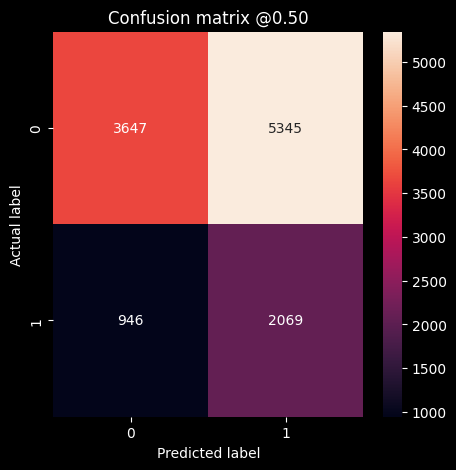

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

plot_cm(test_labels, test_predictions)
